In [1]:
import numpy as np
import json
import os
import os.path

import keras
from keras.layers import Input
from keras_applications import inception_v3, inception_resnet_v2, resnet
from keras.preprocessing import image

import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
#Load models, paper uses : 
# - Inception V3, V3 adv & V4, (adv is pre trained)
# - Inception Resnet V2
# - Resnet V2 152, 150 & 50

# https://keras.io/applications
input_tensor = Input(shape=(299, 299, 3))
i_v3_model = inception_v3.InceptionV3(weights='imagenet', input_tensor=input_tensor,
    backend=keras.backend, layers=keras.layers, models=keras.models, utils=keras.utils)

# i_rn_v2_model = inception_resnet_v2.InceptionResNetV2(weights='imagenet', input_tensor=input_tensor,
#     backend=keras.backend, layers=keras.layers, models=keras.models, utils=keras.utils)

# rn50_model = resnet.ResNet50(weights='imagenet', input_tensor=input_tensor,
#     backend=keras.backend, layers=keras.layers, models=keras.models, utils=keras.utils)

# rn152_model = resnet.ResNet152(weights='imagenet', input_tensor=input_tensor,
#     backend=keras.backend, layers=keras.layers, models=keras.models, utils=keras.utils)

96116736/96112376 [==============================] - 12s 0us/step


In [3]:
RN50 = 'RN50'
RN152 = 'RN152'
I_V3 = 'I_V3'
I_RN_V2 = 'I_RN_V2'


#Execute classification
def classify(img, model):

    # ugly
    if model == 'RN50':
        model = rn50_model
        application = resnet
    elif model == 'RN152':
        model = rn152_model
        application = resnet
    elif model == 'I_V3':
        model = i_v3_model
        application = inception_v3
    elif model == 'I_RN_V2':
        model = i_rn_v2_model
        application = inception_resnet_v2
        
    # preprocess
    img_prep = image.img_to_array(img)
    img_prep = np.expand_dims(img_prep, axis=0)
    img_prep = application.preprocess_input(img_prep,
        backend=keras.backend, layers=keras.layers, models=keras.models, utils=keras.utils)
    # predict
    predictions = model.predict(img_prep)
    #results
    return application.decode_predictions(predictions, top=2, utils=keras.utils)[0]

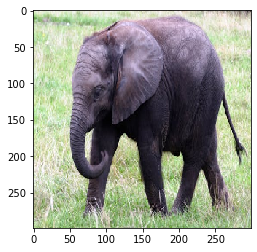

40960/35363 [==================================] - 0s 0us/step
[('n02504458', 'African_elephant', 0.46171185), ('n01871265', 'tusker', 0.31485292)]


In [4]:
# Load image
img_path = 'images/test_elephant.jpg'
img = image.load_img(img_path, target_size=(299, 299))
plt.imshow(img)
plt.show()

print(classify(img, I_V3))
# print(classify(img, I_RN_V2))
# print(classify(img, RN50))
# print(classify(img, RN152))

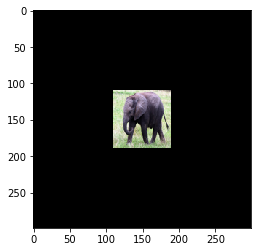

[('n02504458', 'African_elephant', 0.70845884), ('n01871265', 'tusker', 0.22461556)]


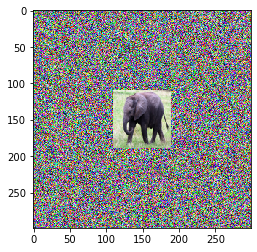

[('n02504458', 'African_elephant', 0.68296176), ('n01871265', 'tusker', 0.23695356)]


In [9]:
center_size = 79
start = int((299 - center_size) / 2)
end = int((299 - center_size) / 2 + center_size)


img_center = img.resize((center_size,center_size))
pixels_center = np.array(img_center)

zeros = np.full((299,299,3), 0, dtype=np.int)
zeros[start:end, start:end, :] = pixels_center

plt.imshow(zeros)
plt.show()
print(classify(zeros, I_V3))

adv_program = np.random.rand(299,299,3) * 255
adv_program = adv_program.astype(int)
adv_program[start:end, start:end, :] = pixels_center
plt.imshow(adv_program)
plt.show()
print(classify(adv_program, I_V3))

In [10]:
def test(images, adv_program):
    results = []
    for class_images in images:
        class_results = []
        for img in class_images:
            adv_program[start:end, start:end, :] = img
            # plt.imshow(adv_program)
            # plt.show()
            class_results.append(classify(adv_program, I_V3)[0][1])
        results.append(class_results)

        if not (class_results.count(class_results[0]) == len(class_results)):
            return (False, results)
        
    return (True, results)
 


def getImage(name):
    return image.load_img('images/'+name+'.png', target_size=(center_size, center_size))

def classImages(nr):
    class_names = [nr+'_1', nr+'_2', nr+'_3']
    return [getImage(name) for name in class_names]
    

adv_program = np.random.rand(299,299,3) * 255
adv_program = adv_program.astype(int)

test([classImages('2'), classImages('6')], adv_program)

(False, [['switch', 'switch', 'monitor']])

In [30]:
import itertools
from IPython.display import clear_output, display

for i in itertools.count(0):
    adv_program = np.random.rand(299,299,3) * 255
    adv_program = adv_program.astype(int)

    result = test([classImages('2'), classImages('6')], adv_program)
    clear_output(wait=True)
    display(i, result[1])

    if result[0]:
        break

4

[['switch', 'switch', 'switch'],
 ['digital_clock', 'digital_clock', 'digital_clock']]

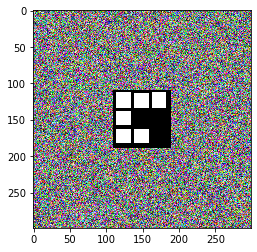

In [29]:
plt.imshow(adv_program)
plt.show()
import pickle
pickle.dump(adv_program, open('adv_program', 'wb'))


In [ ]:
from math import log, inf

def evaluate(images: {str: []}, adv_program: []):
    results = {}
    for k, class_images in images.items():
        class_results = []
        for img in class_images:
            adv_program[start:end, start:end, :] = img
#             Append best match
            class_results.append(classify(adv_program, I_V3)[0][1])
        
        results[k] = class_results

    return results

def computeLoss(results: {str: []}):
    label_map = dict()
    loss = 0
    for k, class_result in results.items():
        
        most_common = max(set(class_result), key = class_result.count)
        count = class_result.count(most_common)
        probability = count/len(class_result)
        
        label_map[k]= most_common
        loss = loss - log(probability)
            
    return loss

# computeLoss({'1':[1,2,2,2,2,3], '2': [2,3,4,3,3,3,1,3,34,4,4,4,4,4]})

CENTER_SIZE = 79
LABELS = ['1', '2', '3', '4', '5', '6', '7', '8', '9']
import glob

def loadImages():
    images = dict()
    
    for label in LABELS:
        files = glob.glob("allSquares/squares"+label+"_*.png")
        images[label] = [image.load_img(f, target_size=(CENTER_SIZE, CENTER_SIZE)) for f in files[:3]]

    return images

def train():
    best_adv_program = []
    best_loss = inf
    
    images = loadImages()
    
    for i in itertools.count(0):
    
        adv_program = np.random.rand(299,299,3) * 255
        adv_program = adv_program.astype(int)

        result = evaluate(images, adv_program)
        loss = computeLoss(result)
        
        if loss < best_loss:
            best_loss = loss
            best_adv_program = adv_program
            clear_output(wait=True)
            display(i, best_loss)
        
        print(i, end='\r')
        
        if loss < 0.05:
            break
            
train()

54

0.8109302162163289

In [41]:
# Program to find most frequent 
# element in a list 
def most_frequent(List):
    print(List)
    print(set(List))
    return max(set(List), key = List.count) 

List = [2, 1, 2, 2, 1, 3] 
print(most_frequent(List)) 

[2, 1, 2, 2, 1, 3]
{1, 2, 3}
['__call__', '__class__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__name__', '__ne__', '__new__', '__qualname__', '__reduce__', '__reduce_ex__', '__repr__', '__self__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__text_signature__']
2
